In [1]:
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay, confusion_matrix


# for dataset generator
from keras.utils import image_dataset_from_directory

# for data augmentation
from keras.preprocessing.image import ImageDataGenerator  


# for save model and to bring model 
from keras.models import load_model 

# 
from keras.datasets import mnist


import keras_tuner as k
from keras.layers import Dense, Dropout, BatchNormalization, Input    # creates fully connected layers
from sklearn.metrics import accuracy_score 
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay 
from sklearn.metrics import confusion_matrix
from keras.regularizers import L1,L2,L1L2
from keras.initializers import Zeros,ones,GlorotNormal,GlorotUniform,HeNormal,HeUniform,RandomNormal,RandomUniform

from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, TensorBoard

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train = ImageDataGenerator(rotation_range=90, horizontal_flip=True,
    vertical_flip=True, rescale = 1./255)

test = ImageDataGenerator(rescale = 1./255)


In [3]:
traing = train.flow_from_directory(r"/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train",
                                   target_size=(224,224), class_mode='sparse',batch_size=32,)

testg = test.flow_from_directory(r"/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test",
                                 target_size=(224,224), class_mode='sparse',batch_size=32,)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [4]:
vgg16 = VGG16(include_top=False,weights="imagenet",input_shape=(224,224,3),)

58889256/58889256 [==============================] - 2s 0us/step


In [5]:
vgg16.layers

In [6]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(224,224, 3)))
    
    model.add(vgg16)
    model.add(Flatten())

    for i in range(hp.Int("hidden_layers", min_value = 10, max_value = 100, step = 2)):
        model.add(Dense(units = hp.Int("neurons{}".format(i), min_value = 4, max_value = 100, step = 2),
                        activation=hp.Choice("activation", values = ["sigmoid", "tanh", "relu"]),
                        kernel_initializer=hp.Choice("weight_init",values=["glorot_uniform","glorot_normal","he_uniform","he_normal"])))
    
    model.add(Dropout(rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
    model.add(Dense(9, activation='softmax'))
        
    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'adam', 'rmsprop', 'adadelta'])

    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_choice, metrics=['accuracy'])

    return model


In [8]:
tuner = k.RandomSearch(build_model, objective="val_accuracy",max_trials=5,directory=r"keras_tuner")

tuner.search(traing, epochs=20, validation_data=testg)

Trial 5 Complete [00h 17m 06s]
val_accuracy: 0.1355932205915451

Best val_accuracy So Far: 0.19491524994373322
Total elapsed time: 01h 29m 04s


In [9]:
 tuner.search_space_summary()

Search space summary
Default search space size: 97
hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 2, 'sampling': 'linear'}
neurons0 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 100, 'step': 2, 'sampling': 'linear'}
activation (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'tanh', 'relu'], 'ordered': False}
weight_init (Choice)
{'default': 'glorot_uniform', 'conditions': [], 'values': ['glorot_uniform', 'glorot_normal', 'he_uniform', 'he_normal'], 'ordered': False}
neurons1 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 100, 'step': 2, 'sampling': 'linear'}
neurons2 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 100, 'step': 2, 'sampling': 'linear'}
neurons3 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 100, 'step': 2, 'sampling': 'linear'}
neurons4 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_va

In [10]:
tuner.results_summary()

Results summary
Results in keras_tuner/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
hidden_layers: 84
neurons0: 90
activation: relu
weight_init: he_uniform
neurons1: 10
neurons2: 80
neurons3: 80
neurons4: 96
neurons5: 94
neurons6: 48
neurons7: 72
neurons8: 44
neurons9: 46
dropout_rate: 0.1
optimizer: adadelta
neurons10: 50
neurons11: 4
neurons12: 38
neurons13: 88
neurons14: 26
neurons15: 52
neurons16: 98
neurons17: 72
neurons18: 82
neurons19: 46
neurons20: 78
neurons21: 88
neurons22: 72
neurons23: 66
neurons24: 76
neurons25: 56
neurons26: 58
neurons27: 86
neurons28: 60
neurons29: 88
neurons30: 80
neurons31: 32
neurons32: 56
neurons33: 32
neurons34: 84
neurons35: 28
neurons36: 6
neurons37: 72
neurons38: 28
neurons39: 12
neurons40: 32
neurons41: 30
neurons42: 38
neurons43: 94
neurons44: 50
neurons45: 58
neurons46: 24
neurons47: 68
neurons48: 74
neurons49: 58
neurons50: 10
neurons51: 28
neurons52: 80
neurons53: 9

In [ ]:
tuner.get_best_hyperparameters()[0].values

{'hidden_layers': 84,
 'neurons0': 90,
 'activation': 'relu',
 'weight_init': 'he_uniform',
 'neurons1': 10,
 'neurons2': 80,
 'neurons3': 80,
 'neurons4': 96,
 'neurons5': 94,
 'neurons6': 48,
 'neurons7': 72,
 'neurons8': 44,
 'neurons9': 46,
 'dropout_rate': 0.1,
 'optimizer': 'adadelta',
 'neurons10': 50,
 'neurons11': 4,
 'neurons12': 38,
 'neurons13': 88,
 'neurons14': 26,
 'neurons15': 52,
 'neurons16': 98,
 'neurons17': 72,
 'neurons18': 82,
 'neurons19': 46,
 'neurons20': 78,
 'neurons21': 88,
 'neurons22': 72,
 'neurons23': 66,
 'neurons24': 76,
 'neurons25': 56,
 'neurons26': 58,
 'neurons27': 86,
 'neurons28': 60,
 'neurons29': 88,
 'neurons30': 80,
 'neurons31': 32,
 'neurons32': 56,
 'neurons33': 32,
 'neurons34': 84,
 'neurons35': 28,
 'neurons36': 6,
 'neurons37': 72,
 'neurons38': 28,
 'neurons39': 12,
 'neurons40': 32,
 'neurons41': 30,
 'neurons42': 38,
 'neurons43': 94,
 'neurons44': 50,
 'neurons45': 58,
 'neurons46': 24,
 'neurons47': 68,
 'neurons48': 74,
 'neuro

In [ ]:
fmodel = tuner.get_best_models(num_models = 1)[0]
fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 90)                2258010   
                                                                 
 dense_1 (Dense)             (None, 10)                910       
                                                                 
 dense_2 (Dense)             (None, 80)                880       
                                                                 
 dense_3 (Dense)             (None, 80)                6480      
                                                                 
 dense_4 (Dense)             (None, 96)                7

In [21]:
#es=EarlyStopping(monitor="val_loss",min_delta=0.01,patience=3,start_from_epoch=7,verbose=1) 

mc=ModelCheckpoint(r"model_checkpoint\model{epoch}.h5",monitor='val_loss',verbose=1,save_best_only=True)

In [ ]:
csv=CSVLogger(r"log.csv")

In [22]:
his = fmodel.fit_generator(traing, steps_per_epoch = 2239//32, epochs = 100,validation_data = testg, validation_steps = 118//32 , callbacks = [mc,csv])

/tmp/ipykernel_47/1878553204.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his = fmodel.fit_generator(traing, steps_per_epoch = 2239//32, epochs = 100,validation_data = testg, validation_steps = 118//32 , callbacks = [mc,csv])


Epoch 1/100
69/69 [==============================] - ETA: 0s - loss: 1.9661 - accuracy: 0.3126
Epoch 1: val_loss improved from inf to 2.16429, saving model to model_checkpoint\model1.h5
69/69 [==============================] - 54s 782ms/step - loss: 1.9661 - accuracy: 0.3126 - val_loss: 2.1643 - val_accuracy: 0.1979
Epoch 2/100
69/69 [==============================] - ETA: 0s - loss: 1.9720 - accuracy: 0.3222
Epoch 2: val_loss did not improve from 2.16429
69/69 [==============================] - 49s 714ms/step - loss: 1.9720 - accuracy: 0.3222 - val_loss: 2.2216 - val_accuracy: 0.1562
Epoch 3/100
69/69 [==============================] - ETA: 0s - loss: 1.9631 - accuracy: 0.3267
Epoch 3: val_loss did not improve from 2.16429
69/69 [==============================] - 50s 720ms/step - loss: 1.9631 - accuracy: 0.3267 - val_loss: 2.2137 - val_accuracy: 0.1458
Epoch 4/100
69/69 [==============================] - ETA: 0s - loss: 1.9467 - accuracy: 0.3280
Epoch 4: val_loss did not improve from 

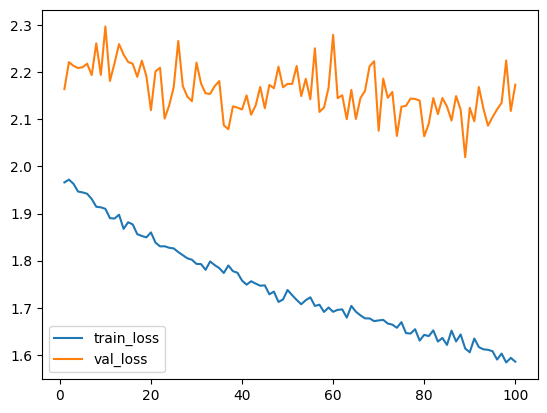

In [23]:
plt.plot(range(1,101),his.history["loss"],label="train_loss")
plt.plot(range(1,101),his.history["val_loss"],label="val_loss")
plt.legend()

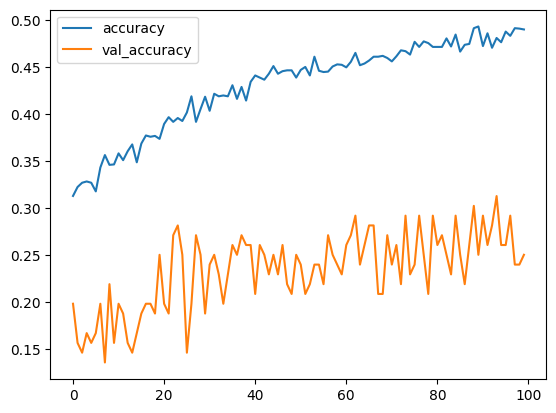

In [24]:
plt.plot(his.history['accuracy'], label='accuracy')
plt.plot(his.history['val_accuracy'], label='val_accuracy')
plt.legend(loc="upper left")
plt.show()

In [25]:
prediction = fmodel.predict(testg)

4/4 [==============================] - 5s 1s/step


In [40]:
import numpy as np

predicted=np.where(prediction>=0.5,1,0) 

In [41]:
predicted

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
predicted = np.argmax(predicted)
predicted

39

In [42]:
print('accuracy:',accuracy_score(testg.labels,predicted)) 

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [ ]:
import cv2

In [ ]:
img = cv2.imread("/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0024515.jpg")

In [ ]:
img.shape

In [ ]:
plt.imshow(img)

In [ ]:
img1 = img.reshape(1,450, 600,3)

In [ ]:
fm = fmodel.predict(img1)
fm